<a href="https://colab.research.google.com/github/ReynaldoHdz/Cosechadores-Multiagentes/blob/main/HarvesterQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install agentpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 963.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00


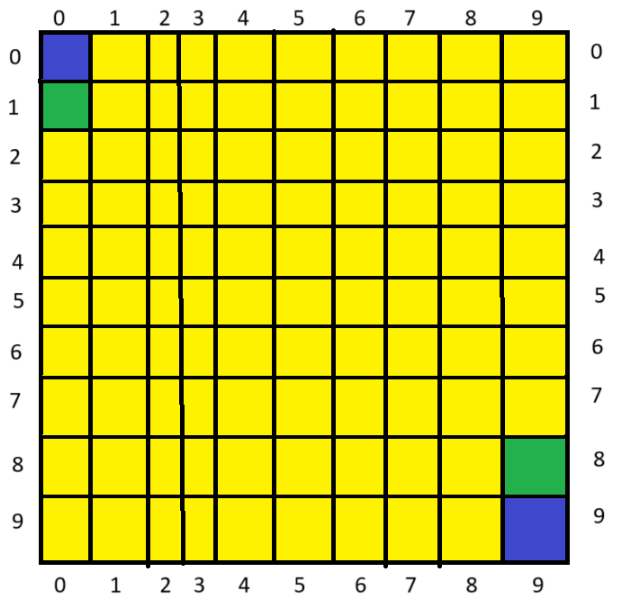

In [ ]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd

In [ ]:
# Q-learning algorithm parameters
alpha = 0.8  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.07  # Probability of exploration

size = 7

Q_table_harvester = np.zeros((size, size, 4))
Q_table_tractor = np.zeros((size, size, 4))

In [ ]:
class HarvesterAgent(ap.Agent):

  def setup(self):

    # Initialize Q-table, states, actions, etc.
    global Q_table_harvester

    self.Q = Q_table_harvester # 4 possible actions (up, down, left, right)
    self.state = (0,0)
    self.action = 0
    self.last_state = (0,0)
    self.crops_harvested = 0

    self.track = 2

  def choose_action(self, state):

    # Choose the next action based on exploration-exploitation trade-off (e-greedy)
    global epsilon
    if np.random.rand() < epsilon:
      self.action = np.random.randint(4)  # Random exploration
    else:
      self.action = np.argmax(self.Q[state]) # Gets the index of the highest value

  def take_action(self):

    # Move the harvester based on the selected action (assuming 4 possible movements)
    movements = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    movement = movements[self.action]

    new_state = tuple(np.add(self.state, movement))

    # Update state (position)
    if 0 <= new_state[0] < self.p.size and 0 <= new_state[1] < self.p.size:
        self.last_state = self.state
        self.state = new_state

    return movement

  def update_Q_table(self, state, action, reward, next_state):

    # Update Q-values based on the Q-Learning algorithm
    global Q_table_harvester, alpha, gamma

    self.Q[state][action] = (1 - alpha) * self.Q[state][action] + alpha * (reward + gamma * np.max(self.Q[next_state]))

    Q_table_harvester = self.Q


class TractorAgent(ap.Agent):

  def setup(self):

    # Initialize Q-table, states, actions, etc.
    pass # 4 possible actions (up, down, left, right)
    self.track = 3

  def choose_action(self, state):

    # Choose the next action based on exploration-exploitation trade-off
    pass

  def update_Q_table(self, state, action, reward, next_state):

    # Update Q-values based on the Q-Learning algorithm
    pass

class CropAgent(ap.Agent):

  def setup(self):

    self.track = 1

    # Condition 0: Harvested, 1: Not harvested
    self.status = 1



In [ ]:
class HarvestModel(ap.Model):

  def setup(self):

    # Create agents (crops, harvesters, tractors)
    self.crops = ap.AgentList(self, self.p.crops, CropAgent)
    self.harvesters = ap.AgentList(self, 1, HarvesterAgent)
    self.tractors = ap.AgentList(self, 2, TractorAgent)

    # Create grid (field)
    self.field = ap.Grid(self, [self.p.size]*2, check_border=True, track_empty=True)

    # Add two harvesters and two tractors at opposite corners
    self.field.add_agents(self.harvesters,[(0,0)])
    #self.field.add_agents(self.harvesters,[(1,0),(self.p.size - 2, self.p.size - 1)])
    #self.field.add_agents(self.tractors, [(0,0),(self.p.size - 1, self.p.size - 1)])

    for harvester in self.harvesters:
      harvester.state = self.field.positions[harvester]

    # Populate the field with crops
    self.field.add_agents(self.crops, random=False, empty=True)

  def step(self):

    for harvester in self.harvesters:
      # Store the state before the action
      harvester.last_state = harvester.state

      # Choose action based on the current state
      harvester.choose_action(self.field.positions[harvester])

      # Take action and move the harvester
      self.field.move_by(harvester, harvester.take_action())



      # Calculate reward

      for crop in self.crops:
        if self.field.positions[crop] == self.field.positions[harvester] and crop.status == 1:
          crop.status = 0
          crop.track = 0
          harvester.crops_harvested += 1
          reward = 10  # Accumulate reward for each harvested crop
          break
        elif self.field.positions[crop] == self.field.positions[harvester] and crop.status == 0:
          reward = -1  # Accumulate reward for each harvested crop
          break
        else:
          reward = -10  # Penalty for wasting a step without harvesting anything



      # Update Q-table for the harvester
      harvester.update_Q_table(harvester.last_state, harvester.action, reward, harvester.state)

    # Simulation ends when there are no crops left to harvest
    if len(self.crops.select(self.crops.status == 0)) == 0:
      self.end()

  def end(self):

    self.report('Harvested crops: ', self.harvesters.crops_harvested)

In [ ]:
parameters = {
  'crops': 48,
  'size': 7, # Height and length of the field
  'steps': 300,
}

model = HarvestModel(parameters)
results = model.run()

Completed: 300 steps
Run time: 0:00:00.172281
Simulation finished


In [ ]:
print(results.arrange_reporters())
print(Q_table_harvester)

   index                                     seed Harvested crops: 
0      0  278559093781760386651415060263391707660              [48]
[[[-336.     -432.6    -336.     -322.    ]
  [-336.     -336.     -538.86   -336.    ]
  [-336.     -336.     -336.     -432.6   ]
  [-336.     -432.6    -538.86   -635.46  ]
  [-648.48   -635.46   -538.86   -648.48  ]
  [-648.48   -639.66   -648.48   -845.3424]
  [-939.0864 -803.082  -711.984  -648.48  ]]

 [[-336.     -432.6    -336.     -635.46  ]
  [-336.     -322.     -538.86   -432.6   ]
  [-432.6    -322.     -336.     -336.    ]
  [-639.66   -644.28   -336.     -336.    ]
  [-336.     -432.6    -538.86   -432.6   ]
  [-432.6    -648.48   -336.     -432.6   ]
  [-677.46   -677.46   -538.86   -648.48  ]]

 [[-639.66   -432.6    -336.     -336.    ]
  [-336.     -432.6    -538.86   -336.    ]
  [-336.     -644.28   -538.86   -336.    ]
  [-639.66   -436.8    -336.     -336.    ]
  [-639.66   -644.28   -547.68   -322.    ]
  [-648.48   -635.46   -

In [ ]:
exp = ap.Experiment(HarvestModel, parameters, iterations=500)
results = exp.run()

Scheduled runs: 500
Completed: 500, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:20.849623


In [ ]:
print(results.arrange_reporters())

     iteration                                     seed Harvested crops: 
0            0   18959427961936762394492642937568997075              [48]
1            1   42741275346238862944421989945532950386              [48]
2            2  116396027256612137242871312101995192886              [45]
3            3   52301604250580162493561757161259810090              [48]
4            4  223383427807927673278172689837531821089              [46]
..         ...                                      ...               ...
495        495  339706178845323401886186378835701839044              [28]
496        496  287186598663779261573807009454366708030              [23]
497        497  324275760737681657058795764274623831526              [25]
498        498   17086877320767791048495882749487026162              [38]
499        499  181013280077791085745275715520484380266              [29]

[500 rows x 3 columns]


In [ ]:
def animation_plot(model, ax):
    wheat_grid = model.field.attr_grid('track')
                    # ground       crop        harvester      tractor
    color_dict = {0:'#964B00', 1:'#ffff00', 2:'#154f30', 3: '#0000ff', None:'#ff0000'}
    ap.gridplot(wheat_grid, color_dict=color_dict, ax=ax, convert=True)
    ax.set_title(f"Simulation of a harvest\n"
                 f"Time-step: {model.t}, Crops harvested: "
                 f"{len(model.crops.select(model.crops.status == 0))}"
                 f", Harvester position: {model.field.positions[model.harvesters[0]]}")

fig, ax = plt.subplots()
model = HarvestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
HTML(animation.to_jshtml())

In [ ]:
model = ap.Model()
class blah(ap.Agent):
  def setup(self):
    self.state = 2
agents = ap.AgentList(model, 1, blah)
grid = ap.Grid(model, (10, 10), track_empty=True)
grid.add_agents(agents,[(0,0)])

grid.move_by(agents[0], (0,1))
grid.move_by(agents[0], (0,1))

print(grid.positions[agents[0]])

(0, 2)


In [ ]:
model = ap.Model()
harvesters = ap.AgentList(model,2)
crops = ap.AgentList(model,98, CropAgent)
field = ap.Grid(model, (10, 10), track_empty=True)
field.add_agents(harvesters,[(0,0),(9,9)])
field.add_agents(crops, random=True, empty=True)

for harvester in harvesters:
  print("Harvester")
  print(field.positions[harvester])
  for crop in field.neighbors(harvester):
    print(crop.type)
    print(field.positions[crop])
    print(crop.status)

len(crops.select(crops.status == 0))

for crop in crops:
  print(field.positions[crop])

In [ ]:
x = [3,2]
y = [1,1]
x = (3,2)
y = (1,1)
ans = np.add(x,y)
tuple(ans)
ans2 = np.add(ans, y)
ans2

hi = (0,1)
print(hi)
hi = (4,4)
print(hi)

In [ ]:
for crop in self.crops:
  if crop.type == "CropAgent" and self.field.positions[crop] == self.field.positions[harvester]:
    crop.status = 0
    crop.sate = False
    harvester.crops_harvested += 1
    reward = 10
  else:
    reward = -1  # Penalty for wasting a step without harvesting anything

In [ ]:
# list out keys and values separately
      allTerrainPositions = self.field.positions
      key_list = list(allTerrainPositions.keys())
      val_list = list(allTerrainPositions.values())
      # print key with val 0,0
      #print(allTerrainPositions)
      position = val_list.index(self.field.positions[harvester])
      agent_in_this_position = key_list[position]
      if agent_in_this_position.type == "CropAgent":
        agent_in_this_position.status = 0
        agent_in_this_position.sate = False
        harvester.crops_harvested += 1
        reward = 10
      else:
        reward = -1  # Penalty for wasting a step without harvesting anything


In [ ]:
# movements = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Up, Down, Left, Right
    # new_state = (self.state[0] + movements[self.action][0], self.state[1] + movements[self.action][1])

    up = (-1,0)
    down = (1,0)
    left = (0,-1)
    right = (0,1)
    movement = (0,0)

    if self.action == 0:  # Arriba
      new_state = tuple(np.add(self.state, up))
      movement = up
    elif self.action == 1:  # Abajo
      new_state = tuple(np.add(self.state, down))
      movement = down
    elif self.action == 2:  # Izquierda
      new_state = tuple(np.add(self.state, left))
      movement = left
    else:  # Derecha
      new_state = tuple(np.add(self.state, right))
      movement = right